Dan Pelis\
AAI 628
# Monet Style Transfer
The goal of this notebook is to build a CycleGAN model capable of translating regular photographs to images in the style of the French painter Claude Monet. This follows the task presented by the Kaggle Competition, [I’m Something of a Painter Myself](https://www.kaggle.com/c/gan-getting-started)

In general GANs are classified as unsupervised models meaning they do not require labeled data. Although  GANs are unsupervised, they are actually labeled as a supervised learning task with two-submodules. The first is a “generator” model that is trained to generate new examples. The second is a “discriminator” model that tries to classify examples as either real or generated. The discriminator takes the target dataset as well as the generated images as input and tries to learn to differentiate them. During training these two models play an adversarial game, which ends when the generator is able to fool the discriminator. At this point it is assumed the generator can produce believable images. There are many extensions to the GAN model,original described in [[1]](https://arxiv.org/abs/1406.2661), which included models like cGANs, which take in auxiliary information along with the images and WGANs, where the discriminator is updated more frequently than the generator and Wasserstein loss is used for training. One such extension is the CycleGAN, which seeks cycle consistency so that image translation could be applied in either direction between the source and target domains.

CycleGANs are well known for the excellent performance in Style Translation as well as the fact that they do not require paired examples. Paired examples in this project’s domain would be Monet paintings and their direct photograph counterparts. Obviously it would be very difficult if not impossible to build such a dataset, so instead we can use CycleGANs. This extension of GANs used two generator models and two discriminators. One set for translating from domain A to B (photo to monet painting) and one for domain B to A. Passing an image through both sets of models is called a **cycle**. One of the goals of the CycleGAN is to achieve cycle consistency, meaning that when an image is translated to another domain and then the resulting image is translated back to the original domain, the final image should ideally be identical to the original image.


## Prepare Data

The data I will be using in this notebook can be found under the [Kaggle Competition's data](https://www.kaggle.com/c/gan-getting-started/data) tab. The dataset consists of ~7000 real photographs and 300 monet paintings. The zip file for each class must be downloaded and extracted into the same directory of this notebook.

In [3]:
import os
import shutil

from numpy import random
from numpy import asarray
from numpy import vstack
from numpy import savez_compressed

from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import sys
from PIL import Image
sys.modules['Image'] = Image 

First I split the images for both classes into testing and training sets. This creates a new directory and organize the images into their appropriate subdirectories.

In [2]:
monet_dir = "./monet_jpg"
photo_dir = "./photo_jpg"
monet_files = os.listdir(monet_dir)
photo_files = os.listdir(photo_dir)

Path("./data/monet/train").mkdir(parents=True, exist_ok=True)
Path("./data/monet/test").mkdir(parents=True, exist_ok=True)
Path("./data/photos/train").mkdir(parents=True, exist_ok=True)
Path("./data/photos/test").mkdir(parents=True, exist_ok=True)

for f in monet_files:
    if random.rand(1) < 0.2:
        shutil.move(f'{monet_dir}/{f}', f'./data/monet/test/{f}')
    else:
        shutil.move(f'{monet_dir}/{f}', f'./data/monet/train/{f}')
        
for f in photo_files:
    if random.rand(1) < 0.2:
        shutil.move(f'{photo_dir}/{f}', f'./data/photos/test/{f}')
    else:
        shutil.move(f'{photo_dir}/{f}', f'./data/photos/train/{f}')

In [3]:
# Images are 256x256
# The following functions reads the images in a given directory and stores them in a numpy array in memory
def load_images(path, size=(256,256)):
    data = list()
    for filename in os.listdir(path):
        image = load_img(path + filename, target_size=size)
        image = img_to_array(image)
        data.append(image)
    return asarray(data)

In [5]:
data_path = 'data/'
# Loads in photo and monet files and stacks their test and train sets in combined numpy arrays
photos_train = load_images(data_path + 'photos/train/')
photos_test = load_images(data_path + 'photos/test/')
photos = vstack((photos_train, photos_test))
print(f'Loaded photos: {photos.shape}')

monet_train = load_images(data_path + 'monet/train/')
monet_test = load_images(data_path + 'monet/test/')
monet = vstack((monet_train, monet_test))
print(f'Loaded dataB: {monet.shape}')

# Both arrays are the saved to a compressed file
filename = 'photo2monet.npz'
savez_compressed(filename, photos, monet)
print(f'Saved dataset: {filename}')

Loaded photos: (7038, 256, 256, 3)
Loaded dataB: (300, 256, 256, 3)
Saved dataset: photo2monet.npz


## Define Model
The following section consists of functions capable of creating the different models that will comprise my CycleGAN.

The following cell will install the "keras-contrib" project if it is not already installed. This package grants us access to an implementation of **Instance Normalization**, which is an important feature of CycleGAN discriminators. Unlike Batch Normalization, Instance Normalization normalizes values across each feature for each example rather than across features in a batch. The CycleGAN white paper [1] recommends

In [6]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\dppel\appdata\local\temp\pip-req-build-h8x1czs1
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101654 sha256=0ee0a27a33f3e6d43b02e5291628ed7aca230420c83ed61f692efa0b1b88a407
  Stored in directory: C:\Users\dppel\AppData\Local\Temp\pip-ephem-wheel-cache-dhtb9gas\wheels\bb\1f\f2\b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git 'C:\Users\dppel\AppData\Local\Temp\pip-req-build-h8x1czs1'
You should consider upgrading via the 'c:\users\dppel\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [7]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.optimizers import adam_v2

layer = InstanceNormalization(axis=-1)

### Discriminator
The discriminator in a CycleGAN is a type of image classification deep CNN, called a **PatchGAN**. Like a regular image classifier the discriminator determines the likelihood of the input being part of a specific class (in the case of GAN discriminators the classes are ‘fake’ and ‘real’). However, since the discriminator is a PatchGAN model it outputs the likelihood that a square patch of the input images is of a certain class. This removes the constraint of needing the input images to always be a certain size. The CycleGAN white paper [1] recommends optimizing the model using L2 loss.

In [8]:
def build_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    
    model = Model(in_image, patch_out)
    model.compile(loss='mse', optimizer=adam_v2.Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

### Generator

The generator follows an encoder-decoder architecture, by taking in an image, downsampling it to a bottleneck layer, then upsample the internal representation to the size of the output image.
Before decoding is done the internal representation is interpreted with a number of ResNet layers that use skip connections.

These ResNet blocks are implemented in the function below and follow the implementation in the Official PyTorch implementation.


In [9]:
def resnet_block(n_filters, input_layer):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Concatenate()([g, input_layer])
    return g

In [10]:
def build_generator(image_shape, n_resnet=9):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)

    model = Model(in_image, out_image)
    return model

### Composite Model

Since the generators are not trained directly on input and output images we need to build a composite model which will combine the separate losses that our generators are trained from. The generators are trained based on their relation to their respective discriminators, and with that comes four types of loss. The first is the loss based on the generators images being marked are real or fake by the discriminator, called **adversarial loss**. The second is how well both generators can reproduce an image when working together. This means how close the output image would be to its original form after being passed through both generators. This loss is called **cycle loss** and both forward and backward cycle loss is taken into account. Finally there is the loss representing how close an output image is to its original if the input was part of the target domain. For example if we give the Photo to Monet generator a Monet painting, there should be little change to the image. This loss is called **identity loss**.

In [11]:
def build_composite_model(g_model_1, d_model, g_model_2, image_shape):
    
    g_model_1.trainable = True # Only want to train this model
    d_model.trainable = False
    g_model_2.trainable = False
    
    input_source = Input(shape=image_shape) # Image from source domain
    input_target = Input(shape=image_shape) # Image from target domain
    
    gen1_out = g_model_1(input_source) # Photo -> Monet
    gen2_out = g_model_2(input_target) # Monet -> Photo
    
    output_adversarial = d_model(gen1_out) # Adversarial (Photo -> Monet) -> Real/Fake
    output_identity = g_model_1(input_target) # Identity output (Monet -> Monet)
    output_forward = g_model_2(gen1_out) # Cycle Consistency Forwards (Photo -> Monet) -> Photo
    output_backwards = g_model_1(gen2_out) # Cycle Consistency Backwards (Monet -> Photo) -> Monet
    
    model = Model([input_source, input_target], [output_adversarial, output_identity, output_forward, output_backwards])
    opt = adam_v2.Adam(learning_rate=0.0004, beta_1=0.5)
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

### Utility Functions 
For training we will need both real and fake samples. The functions below provide functionality to support these needs.

In [12]:
def load_real_samples(filename):
    data = load(filename)
    domainA, domainB = data['arr_0'], data['arr_1']
    #
    domainA = (domainA - 127.5) / 127.5 # Scale pixels to [-1,1]
    domainB = (domainB - 127.5) / 127.5 # Scale pixels to [-1,1]
    return [domainA, domainB]

In [13]:
def generate_real_samples(dataset, n_samples, patch_shape):
    indices = randint(0, dataset.shape[0], n_samples) # Random indices in range of dataset
    images = dataset[indices] # Get random images from domain
    labels = ones((n_samples, patch_shape, patch_shape, 1)) # Create class labels for images
    return images, labels

In [14]:
def generate_fake_samples(generator, dataset, patch_shape):
    X = generator.predict(dataset)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [15]:
def save_models(step, monet_generator, photo_generator):
    monet_generator_path = f'monet_generator_{(step+1):6d}.h5'
    photo_generator_path = f'photo_generator_{(step+1):6d}.h5'
    
    monet_generator.save(monet_generator_path)
    photo_generator.save(photo_generator_path)
    print(f'>Saved: {monet_generator_path} and {photo_generator_path}'

The following function generates a plot showing photos and their corresponding generated monet counterparts, from the current generator. This will be used during testing to show the model’s progress.

In [16]:
def generate_example_plot(step, generator, train, name, n_samples=5):
    example_photos, _ = generate_real_samples(train, n_samples, 0)
    example_monets, _ = generate_fake_samples(generator, example_photos, 0)
    example_photos = (example_photos + 1) / 2.0
    example_monets = (example_monets + 1) / 2.0
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(example_photos[i])
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(example_monets[i])
    filename1 = f'{name}_{(step+1):6d}.png'
    pyplot.savefig(filename1)
    pyplot.close()

The CycleGAN white paper describes the discriminators being trained directly on images from the real and fake sets. To control how fast the discriminator learns, the paper suggests keeping a pool of fake images to use for the discriminator’s training. During training when it is time to gather fake images for the discriminator, the model will randomly either grab fake images straight from the generator or take an image from the pool for training and then replace it with a newly generated image. Mixing in these stale images from the pool will slow down the discriminator’s learning and help the generator stay ahead. This process is implemented in the function below. Additionally the paper suggested using a pool of 50 images which is set in the pooling function.

In [17]:
def update_image_pool(pool, images, max_size=50):
    selected = []
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            selected.append(image)
        else:
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)

### Custom Training Function

Since the CycleGAN model requires a more complicated training process, the normal *fit* function cannot be used. Instead we need to write our own function to perform the updates we described previously. The *train_on_batch* function from keras runs a single gradient update on a given batch, providing much more control over the training of our model than the *fit* function. Using this and the utility functions from the previous section, a training function is implemented below. The number of training epochs is taken from the CycGAN white paper and the order of the updates is from the official PyTorch implementation.

I have set the function to generate example plots every 1000 steps and to save the model every 4000 steps. These numbers can be increased to reduce clutter created by the model.


In [20]:
def train(discrim_model_photo, discrim_model_monet, generator_photo_to_monet, generator_monet_to_photo, composite_photo_to_monet, composite_monet_to_photo, dataset):
    n_epochs, n_batch, = 100, 1
    n_patch = discrim_model_photo.output_shape[1]
    photo_train, monet_train = dataset
    photo_pool, monet_pool = list(), list()
    bat_per_epo = int(len(photo_train) / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        # Gather training images
        real_photos, real_photo_labels = generate_real_samples(photo_train, n_batch, n_patch)
        real_monet, real_monet_labels = generate_real_samples(monet_train, n_batch, n_patch)
        fake_photos, fake_photo_labels = generate_fake_samples(generator_monet_to_photo, real_monet, n_patch)
        fake_monet, fake_monet_labels = generate_fake_samples(generator_photo_to_monet, real_photos, n_patch)
        # Update pools
        fake_photos = update_image_pool(photo_pool, fake_photos)
        fake_monet = update_image_pool(monet_pool, fake_monet)
        
        generator_loss2, _, _, _, _  = composite_monet_to_photo.train_on_batch([real_monet, real_photos], [real_photo_labels, real_photos, real_monet, real_photos])
        photo_discrim_loss1 = discrim_model_photo.train_on_batch(real_photos, real_photo_labels)
        photo_discrim_loss2 = discrim_model_photo.train_on_batch(fake_photos, fake_photo_labels)
        generator_loss1, _, _, _, _ = composite_photo_to_monet.train_on_batch([real_photos, real_monet], [real_monet_labels, real_monet, real_photos, real_monet])
        monet_discrim_loss1 = discrim_model_monet.train_on_batch(real_monet, real_monet_labels)
        monet_discrim_loss2 = discrim_model_monet.train_on_batch(fake_monet, fake_monet_labels)
        print(f'>{i+1}, photo_discrim_loss[{photo_discrim_loss1:.3f},{photo_discrim_loss2:.3f}]. monet_discrim_loss[{monet_discrim_loss1:.3f},{monet_discrim_loss2:.3f}], generator_loss[{generator_loss1:.3f},{generator_loss2:.3f}]'
        if (i % 1000) == 0:
            generate_example_plot(i, generator_photo_to_monet, photo_train, 'photo_to_monet')
            generate_example_plot(i, generator_monet_to_photo, monet_train, 'monet_to_photo')
        if (i % 4000) == 0:
            save_models(i, generator_photo_to_monet, generator_monet_to_photo)

## Train Model

Finally, we can call the functions defined in the previous section and train the CycleGAN model. First we load in our compressed dataset from earlier, then define our generators, discriminators, and composite models. Lastly we pass out dataset and models into the train function we defined in the last section and let it run.

In [22]:
dataset = load_real_samples('photo2monet.npz')
image_shape = dataset[0].shape[1:]
generator_photo_to_monet = build_generator(image_shape)
generator_monet_to_photo = build_generator(image_shape)
discrim_model_photo = build_discriminator(image_shape)
discrim_model_monet = build_discriminator(image_shape)
composite_photo_to_monet = build_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
composite_monet_to_photo = build_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
train(discrim_model_photo, discrim_model_monet, generator_photo_to_monet, generator_monet_to_photo, composite_photo_to_monet, composite_monet_to_photo, dataset)

KeyboardInterrupt: 

## Generating Images and Testing
Now that the model has been trained we can test some example images and observe the results.

In [93]:
import random
from numpy import expand_dims
from numpy import load
from keras.models import load_model
from keras.preprocessing.image import load_img
!pip install -q git+https://www.github.com/keras-team/keras-contrib.git
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

You should consider upgrading via the 'c:\users\dppel\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [94]:
# This is the same function as above, but it is repeated here so this section can be run separate
def load_real_samples(filename):
    data = load(filename)
    domainA, domainB = data['arr_0'], data['arr_1']
    #
    domainA = (domainA - 127.5) / 127.5 # Scale pixels to [-1,1]
    domainB = (domainB - 127.5) / 127.5 # Scale pixels to [-1,1]
    return [domainA, domainB]

In [169]:
photos, monet = dataset = load_real_samples('photo2monet.npz') # Load photo and monet images
cust = {'InstanceNormalization': InstanceNormalization}
monet_gen = load_model('g_model_AtoB_036001.h5', cust) # Load photo->monet model
photo_gen = load_model('g_model_BtoA_036001.h5', cust) # Load monet->photo model

In [196]:
'''This function chooses randome indices in the range of the image set, 
then translates them to the target domain, 
and finally plots the orginal and output images side-by-side
'''
def infer_random_images(data, model, num_sample=5):
    images = random.sample(range(1, data.shape[0]), 5)
    print(f'Usings images: {images}')
    image_scr = []
    image_tar = []

    for i in images:
        image_s = data[i-1:i]
        image_scr.append((image_s + 1) / 2.0)
        image_t = model.predict((image_s + 1) / 2.0)
        image_tar.append((image_t + 1) / 2.0)
        
    fig = pyplot.figure(figsize=(12, 20))
    columns = 2
    rows = 4
    index = 0
    for i in range(1, columns*rows +1, 2):
        fig.add_subplot(rows, columns, i)
        pyplot.imshow(image_scr[index][0])
        fig.add_subplot(rows, columns, i+1)
        pyplot.imshow(image_tar[index][0])
        index += 1
    pyplot.show()

### Test Random Images
In the cell below I use the function defined above to translate and view 5 random images from the photo dataset

Usings images: [5193, 2176, 6042, 1599, 2435]


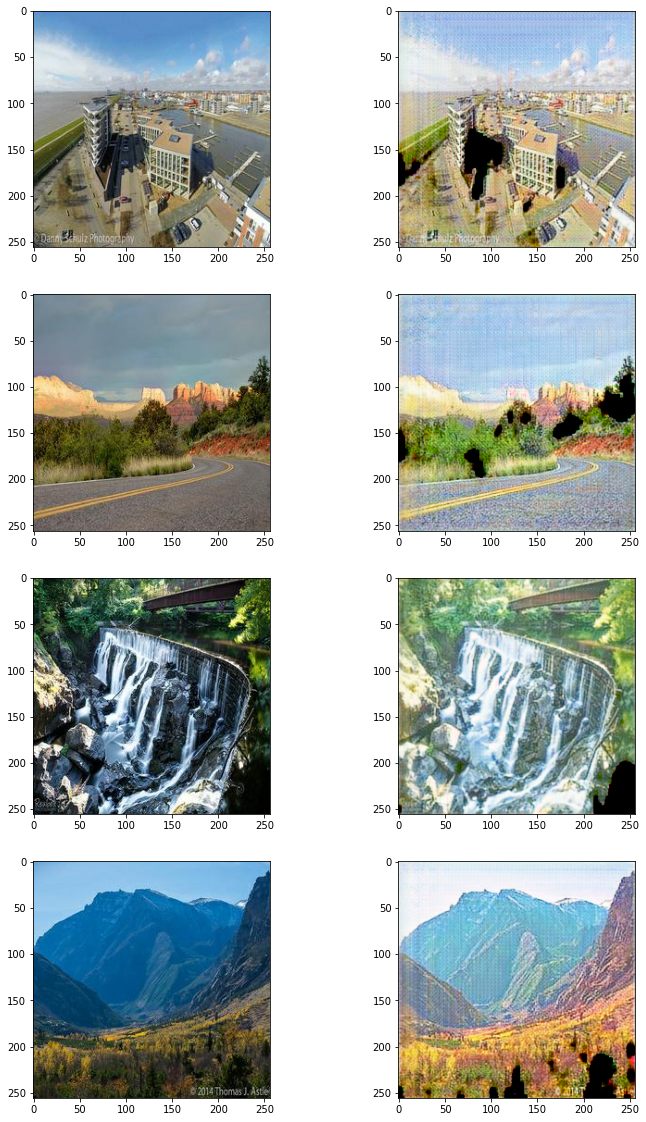

In [216]:
infer_random_images(photos, monet_gen)

Observing the photos above one can see that the translation works relatively well on images containing nature shots, but not well on images with rigid structures such as buildings. In the first photo of the building one can see that the translated image is almost the same as the original just with brighter colors and some distortion. I believe this was caused by the number of sharp edges in the original photo. Monet’s art is often abstract and contains a lot of soft rounded edges even for things like buildings or boats. The other images in this plot contain mostly nature and perform a little better than the first image. I believe that some of the translated images from the photos dataset do look like paintings, however much of Monet’s art contains much less rigid detail than these fake generated images.

Now, out of curiosity I will test translating a random set of monet paintings to photos using the second generator.

Usings images: [271, 8, 280, 263, 256]


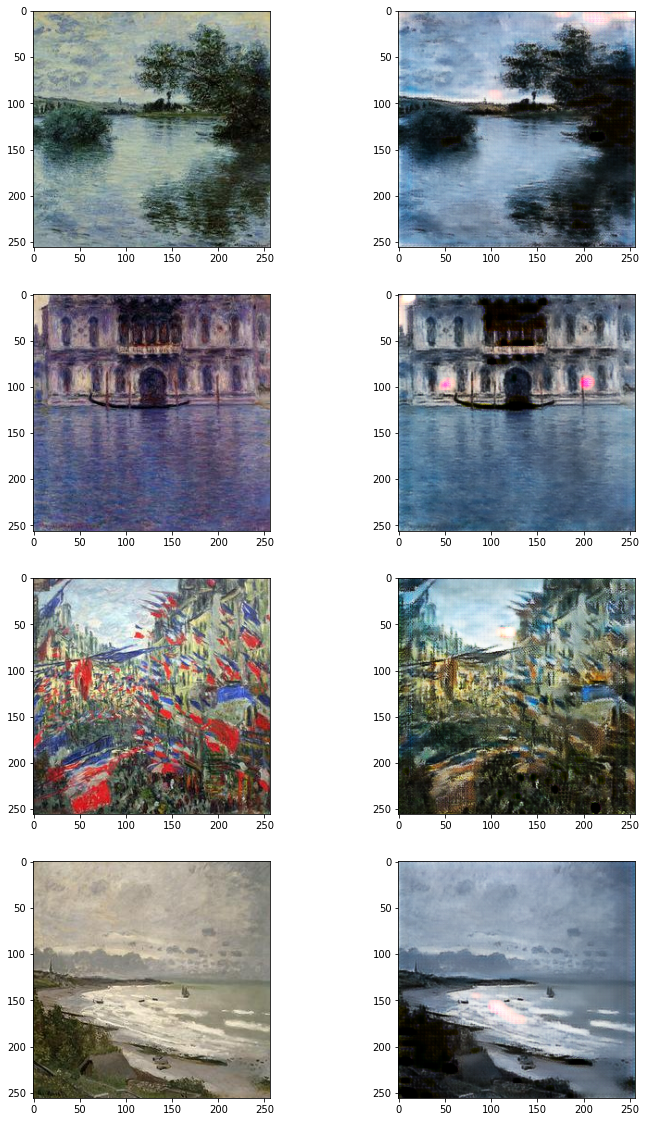

In [221]:
infer_random_images(monet, photo_gen)

Here we have the opposite problem from translating photos to Monet paintings, where the images are too fluid to look like actual photographs. This is again probably due to Monet’s style, which doesn’t give the generator enough fine detail to generate finer edges.

### Test Single Images

Below I will test translation a few more images, however these will not be from the dataset used during the creation of the model. I have downloaded a few nature images from the internet to see how they perform.

In [222]:
'''This function loads images from a file into a pixel array
'''
def load_image(filename, size=(256,256)):
    pixels = load_img(filename, target_size=size)
    pixels = img_to_array(pixels)
    pixels = expand_dims(pixels, 0)
    pixels = (pixels - 127.5) / 127.5
    return pixels

In [224]:
'''This function is similar to infer_random_images, but it is
defined to work on a single given image array
'''
def translate_image(in_path):
    fig = pyplot.figure(figsize=(8, 8))
    fig.text(0.23,0.9,'Original Image')
    fig.text(0.64,0.9,'Translated Image')
    image_s = load_image(in_path)
    image_scr = ((image_s + 1) / 2.0)
    cust = {'InstanceNormalization': InstanceNormalization}
    image_t = model.predict(image_scr)
    fig.add_subplot(2, 2, 1)
    pyplot.imshow(image_scr[0])
    fig.add_subplot(2, 2, 2)
    pyplot.imshow(((image_t[0] + 1) / 2.0))

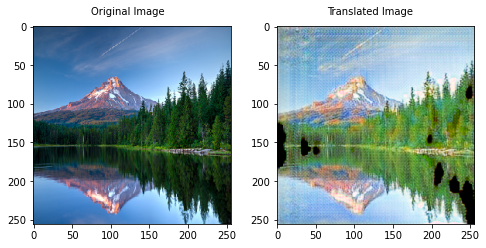

In [163]:
translate_image('test_imgs/mountain.jpg')

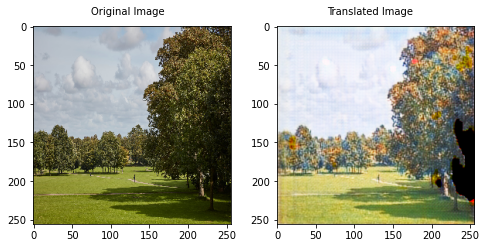

In [164]:
translate_image('test_imgs/park.jpg')

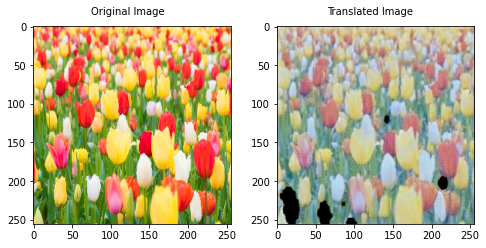

In [165]:
translate_image('test_imgs/flowers.jpg')

After running these test images through the generator one can see that the first two actually performed well. There are some patches of black that are probably due to an issue in the way I am scaling the pixel values. However the rest of the image looks somewhat convincing. The last image did not perform as well and looks as if the contrast was turned down. I believe these images might look as if they performed better because they originally had a higher resolution. The original photos dataset contains images that are 256x256, so displaying them at this size might be the cause of some distortion.

The next two sections test the other types of loss mentioned earlier in the training stage. These are not the purpose of the generators, however I wanted to visualize these concepts.

### Cycle Consistency
Passing a photo through both generators should results in a image close the original

In [150]:
def cycle_consistency(data, model1, model2, num_sample=5):
    images = random.sample(range(1, data.shape[0]), 5)
    print(f'Usings images: {images}')
    image_scr = []
    image_tar = []

    for i in images:
        image_s = data[i-1:i]
        image_scr.append((image_s + 1) / 2.0)
        image_t = model1.predict(image_s)
        image_t = model2.predict(image_t)
        image_tar.append((image_t + 1) / 2.0)
        
    fig = pyplot.figure(figsize=(12, 20))
    columns = 2
    rows = 4
    index = 0
    for i in range(1, columns*rows +1, 2):
        fig.add_subplot(rows, columns, i)
        pyplot.imshow(image_scr[index][0])
        fig.add_subplot(rows, columns, i+1)
        pyplot.imshow(image_tar[index][0])
        index += 1
    pyplot.show()

Usings images: [6054, 1610, 4009, 3832, 3371]


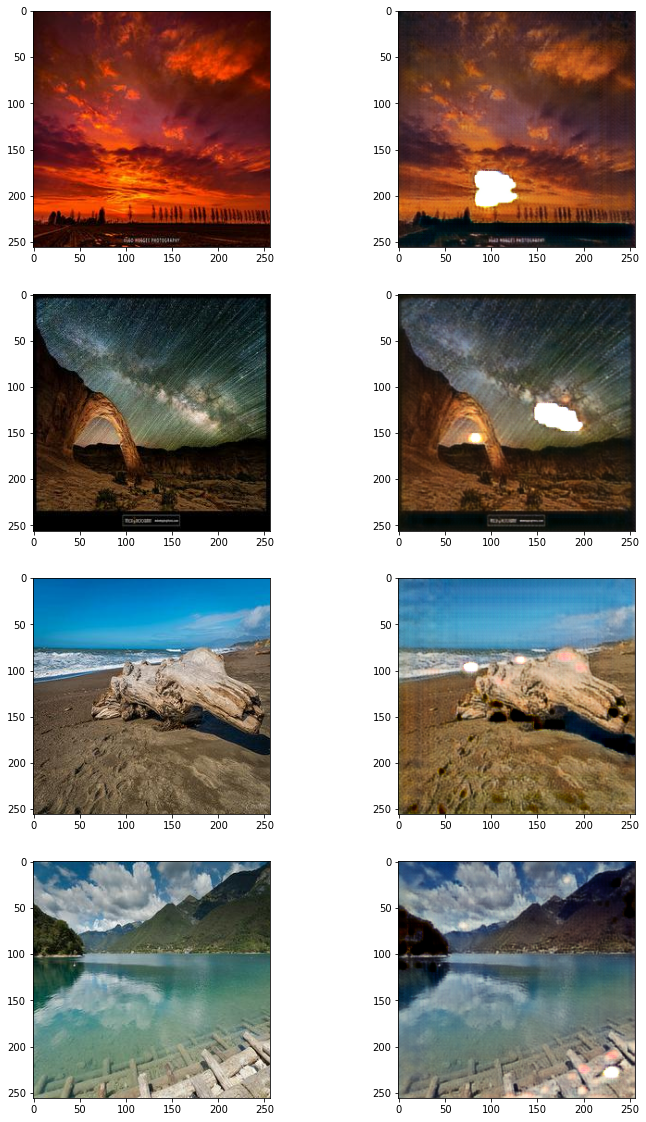

In [144]:
cycle(photos, monet_gen, photo_gen)

Usings images: [49, 199, 35, 88, 144]


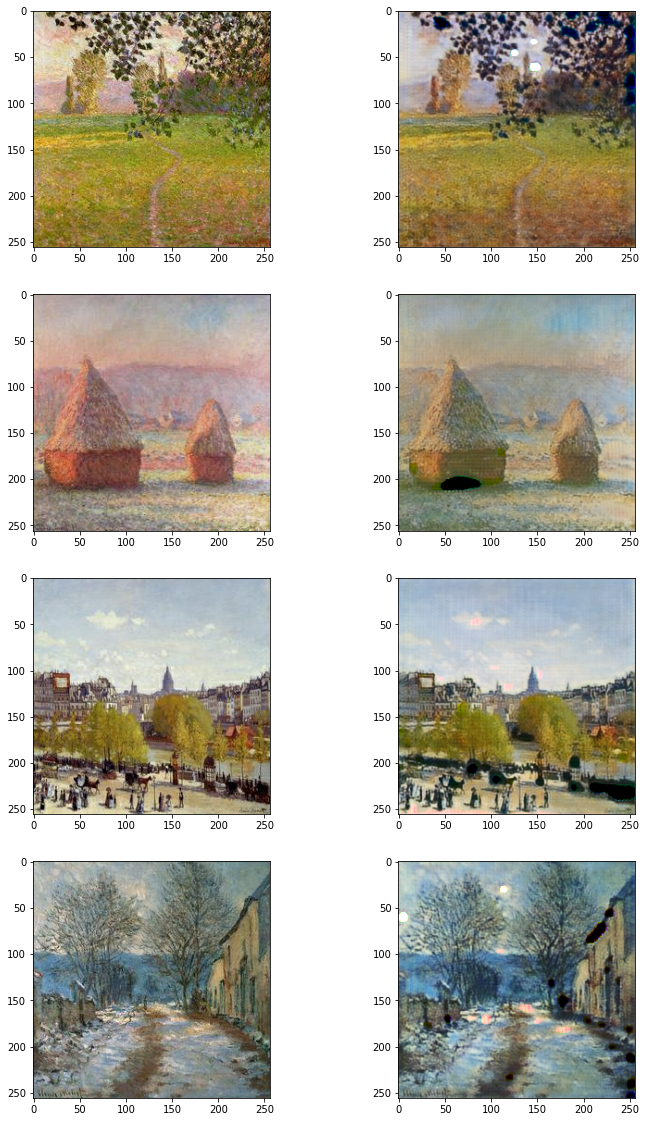

In [145]:
cycle(monet, photo_gen, monet_gen)

From these results one can see that the generators did achieve cycle consistency, since there was very little change between the input and output images. Some did however contain the white or black patches I mentioned earlier

### Identity
If an image of the target domain is passed in, it should not undergo any changes.

Usings images: [4098, 801, 5935, 1003, 3965]


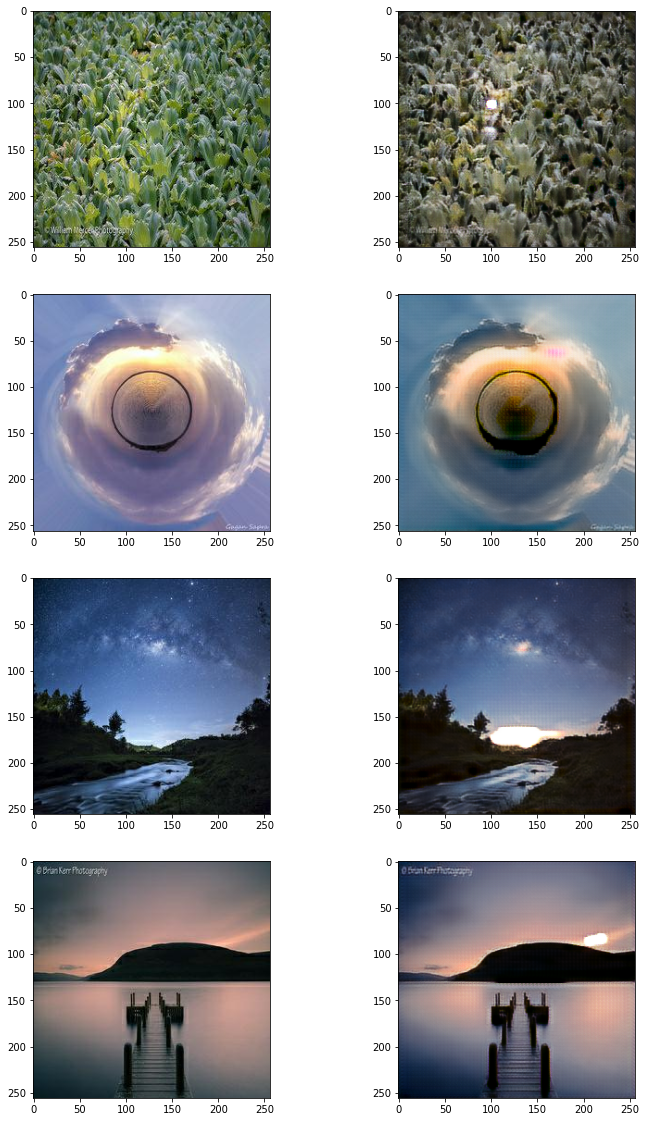

In [148]:
infer_random_images(photos, photo_gen)

Usings images: [213, 217, 204, 77, 174]


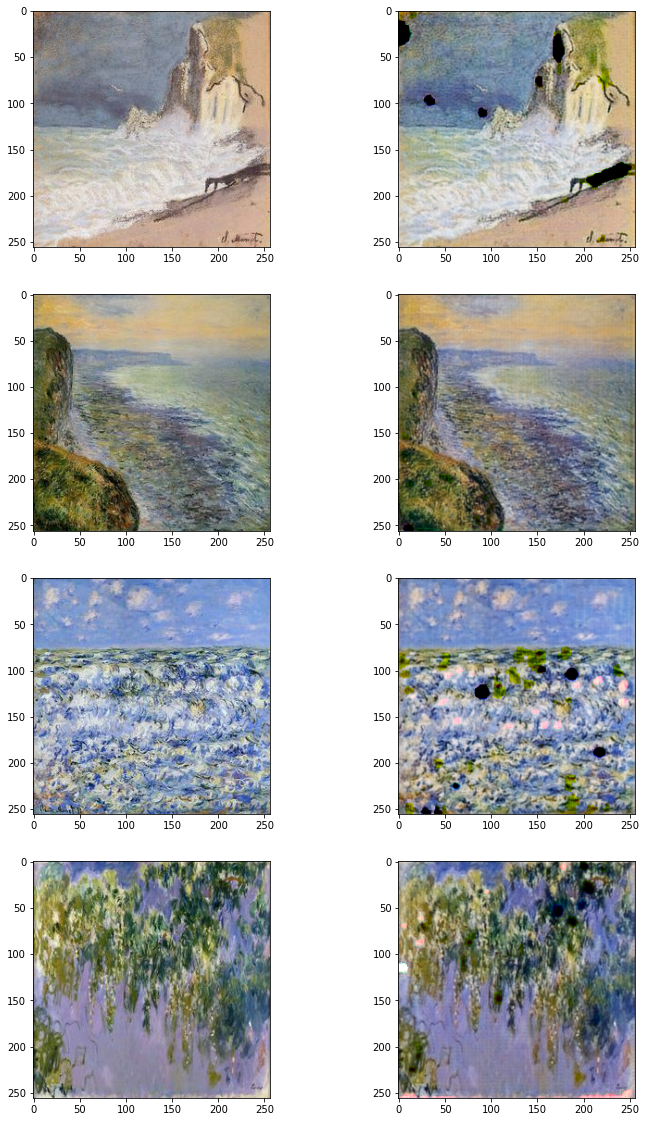

In [149]:
infer_random_images(monet, monet_gen)

Although the results are not as good as the cycle consistency test, the generators did do well minimizing the identity loss. Most of the images saw little change when passed into their respective generators. There are still those black and white patches, probably from pixel values exceeding the 255 limit.

## Results & Improvements

Overall the results of the generators were mediocre at making convincing Monet paintings out of real photos. At the end of training the discriminator was seeing a loss of ~ 0.005 and the generators were both fluctuating around 5. This leads me to believe that the discriminator learned too fast and the generator could not fool the discriminator well. This could lead to the generator trying to fool the discriminator in the wrong way and in turn create improper outputs.

Most of my time was spent on learning the GAN and CycleGAN concepts and training the model. I believe my model would benefit from testing different combinations of layers and learning rates in my generators and discriminators. There are also other improvements that can be made to the structure of the CycleGAN that have shown improvements in other models. One such improvement is implementing **smooth labeling** to the discriminator to help balance the learning between the discriminator and generator. Smooth labelling is a regularization technique that adds noise to the labels. Other suggested improvements include, increasing the batch size, skipping normalization on the first convolutional layer, and switching to batch normalization rather than instance normalization.

## Resources

1. [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks, 2017.](https://arxiv.org/abs/1703.10593) 
    - This is the original white paper which describes CycleGANs. It was used for the key concepts behind this GAN extension and a general outline of the CycleGAN model components.  
    
2. [Cyclegan Tutorial](https://machinelearningmastery.com/cyclegan-tutorial-with-keras/)
    - This is a more in-depth tutorial on constructing a CycleGAN. In their example they constructed a CycleGAN for translating images of horses to zebras.  
    
3. [Multitask-CycleGAN](https://github.com/eveningglow/multitask-CycleGAN)
    - This had some suggested improvements to the CycleGAN structure  